## LFP Preprocessing

THIS NOTEBOOK HAS BEEN EDITED FOR THE PREPROESSING OF THE SOCIAL NAVIGATION TASK

These are magics that provide certain functionality. Specifically, if you edit functions that are called in this notebook, the functions are reloaded so the changes propagate here without needing to reload the notebook.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import pickle
from tqdm import tqdm
from IPython.display import clear_output
import warnings 
import scipy

# I only want to see warnings once
warnings.filterwarnings('ignore')

Note: Different users can have different paths. When sharing code with others, you can define username and use it instead of hardcoding paths.

In [3]:
import getpass
username = getpass.getuser()
print(username)

jainp08


Note: If you have installed the LFPAnalysis package in editable form on Minerva, you must append the local path! This is because Minerva requires that you point your package installs away from the local directory for space reasons, but editable packages have to be installed locally.

THE VERSION USED HERE CAN BE FOUND AT https://github.com/gelanat/LFPAnalysis.git

In [4]:
import sys
sys.path.append(f'/hpc/users/{username}/LFPAnalysis/')
if username=='jainp08':
    sys.path.append(f'/hpc/users/{username}/LFPAnalysis_SNT/')

In [5]:
from LFPAnalysis_SNT import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils, SNT_utils

## Setting variables

In [6]:
subj_ids = ['MS019']
# ['MS008', 'MS009', 'MS019', 'MS020', 'MS030',
#             'MS034', 'MS042', 'MS043', 'MS045', 'MS047', 
#             'MS048', 'MS050', 'MS051', 'MS052', 'MS053',
#             'MS054']
subj_sites = ['MSSM' for _ in subj_ids]
subj_formats = ['edf' for _ in subj_ids]

if username == 'tostag01':
    base_dir = '/sc/arion/projects/OlfMem/tostag01/SocialNav'

if username == 'jainp08':
    base_dir = '/sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG'

In [7]:
load_preproc_data = False
load_reref_data = False

## Pre-process (run 1x): 

In the pre-processing functions below, we: 

1. load the raw data (either a .edf file or a folder of .nlx files) into mne objects for use with the mne toolbox: https://mne.tools/stable/index.html.

2. load the localized electrode names from the .csv or .xlsx file listing their MNI coordinates into the mne object

3. filter and resample as necessary

4. re-reference 

In [8]:
for ix, subj_id in enumerate(subj_ids): 
    site = subj_sites[ix]
    format = subj_formats[ix]
    print(f'Working on subj {subj_id}')
    
    # Set paths
    if format == 'nlx':
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/nlx/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/nlx/'
    else:   
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/'
    
    elec_path = f'{base_dir}/data/{subj_id}/anat/'
    
    # Check if path exists for saving, and if not, make it
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # electrode files could either be csv or excel
    elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
    # There should really only be one, so grab it with the zero-index 
    elec_file = elec_files[0]
    
    ### Pre-process data
    if load_preproc_data:
        mne_data = mne.io.Raw(f'{save_path}raw_ieeg.fif', preload=True)
        
    else:
        # Make MNE file
        mne_data = lfp_preprocess_utils.make_mne(load_path=load_path, 
                                                 elec_path=elec_file,
                                                 format=format,
                                                 return_data=True,
                                                 site=site,
                                                 check_bad=False) # changed this to not annotate anything as bad 

        # Save this data so that you don't need this step again:
        mne_data.save(f'{save_path}/raw_ieeg.fif', overwrite=True)
        
    ### Bipolar re-reference data
    if load_reref_data:
        mne_data_reref = mne.io.read_raw_fif(f'{save_path}/ieeg_bp.fif', preload=True)
    else:
        # Re-reference neural data
        mne_data_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                                  elec_path=elec_file, 
                                                  method='wm', 
                                                  site=site)

        # Save this data so that you don't need this step again:
        mne_data_reref.save(f'{save_path}/ieeg_bp.fif', overwrite=True)

    # Should also save out re-referenced elec_file: 
    elec_data = lfp_preprocess_utils.load_elec(elec_file)
    anode_list = [x.split('-')[0] for x in mne_data_reref.ch_names]
    elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
    elec_df['label'] =  elec_df.label.apply(lambda x: [a for a in mne_data_reref.ch_names if str(x).lower() in a.split('-')[0]][0])

    # Add region to the data frame 

    manual_col = [col for col in elec_df.columns if 'manual' in col.lower()][0]
    all_regions = [] 
    for chan_name in elec_df.label.unique():
        elec_region = analysis_utils.select_rois_picks(elec_df, chan_name, manual_col=manual_col)
        all_regions.append(elec_region) 

    elec_df['SNT_region'] = all_regions
    elec_df['hemisphere'] = elec_df.label.apply(lambda x: x[0])

    elec_df.to_csv(f'{save_path}/labels_bp', index=False)


Working on subj MS019
Extracting EDF parameters from /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/data/MS019/raw/neural/MS019_SocialNav.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3398015  =      0.000 ...  3318.374 secs...
Overwriting existing file.
Writing /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/data/MS019/raw/neural/photodiode.fif
Closing /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/data/MS019/raw/neural/photodiode.fif
[done]
Number of electrodes in the mne file is greater than the number of electrodes in the localization file
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 161 tasks      | elapsed:   15.6s


Overwriting existing file.
Writing /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/data/MS019/raw/neural/lfp_data.fif
Closing /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/data/MS019/raw/neural/lfp_data.fif
[done]
Overwriting existing file.
Writing /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS019/LFP/raw_ieeg.fif
Closing /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS019/LFP/raw_ieeg.fif
[done]
Number of electrodes in the mne file is less than the number of electrodes in the localization file
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=66, n_times=1659188
    Range : 0 ... 1659187 =      0.000 ...  3318.374 secs
Ready.
Added the following bipolar channels:
lacas1-lmoif1, lacas10-lmoif1, lacas2-lmoif1, lacas3-lmoif1, lacas5-lmoif1, lacas6-lmoif1, lacas7-lmoif1, lacas8-lmoif1, lacas9-lmoif1, lagit1-

 - mne_data: a Raw mne object, where the data has been loaded, filtered for line noise, parsed for different data types, and resampled if necessary. 
 
 - mne_data_reref: an mne object containing re-referenced data (either white matter or bipolar)

## NOW look at the data to manually remove channels: 

After bipolar referencing: 

In [ ]:
%matplotlib notebook 

In [ ]:
# Scroll up/down and left/right using your keyboard. CLICK on a channel to turn it 'grey' and mark as a 'bad' channel. 
# If you click a grey channel again it will unmark it. 

mne_data_reref = mne.io.read_raw_fif(f'{save_path}/ieeg_bp.fif', preload=True)
fig = mne_data_reref.plot(start=0, duration=120, n_channels=30, 
                      scalings=mne_data_reref._data.max()/30
                     )

In [ ]:
# ALSO look at the power spectra! 
# You can click on channels here to identify them, and go back to the viz above to mark them as noise if need be

mne_data_reref.compute_psd().plot()

 - mne_dict: a dictionary containing all of your subjects' re-referenced mne data 
 
 - photodiode_dict: a dictionary containing all of your subjects' photodiode data 
 
 - elec_dict: a dictionary containing the paths to your subjects' electrode data 

## Sync behavioral and neural data

Here, we perform a critical step: computing the time offset between the computer that recorded the neural data and the laptop that featured the experiment. 

The function here only requires a **subset** of detected sync signals (i.e. photodiode deflections) to be detected to successfully compute this offset. 

First, you may need to MANUALLY clean the photodiode signal if the recording quality is poor. Load it, plot it, and try to isolate/amplify the pulses. 

Working on subj MS019
13 responses missed for MS019
There are 63 behav syncs detected
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/data/MS019/raw/neural/photodiode.fif...
Isotrak not found
    Range : 0 ... 3398015 =      0.000 ...  3318.374 secs
Ready.
Reading 0 ... 3398015  =      0.000 ...  3318.374 secs...
There are 68 neural syncs detected
Max rval with slope of 1.000180750869814 and offset of -4.048653441513906


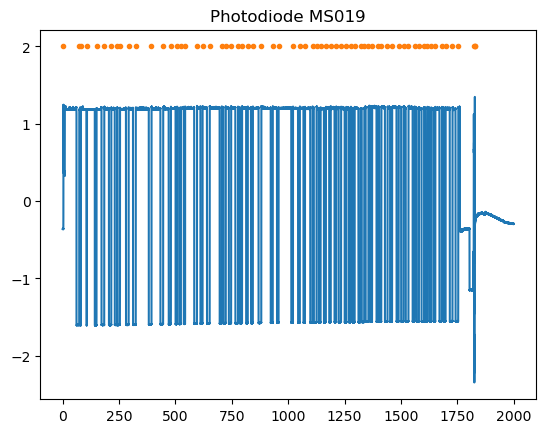

In [9]:
slopes = {f'{x}': 0 for x in subj_ids}
offsets = {f'{x}': 0 for x in subj_ids}

for ix, subj_id in enumerate(subj_ids): 
    site = subj_sites[ix]
    format = subj_formats[ix]
    print(f'Working on subj {subj_id}')
    
    # Set paths
    if format == 'nlx':
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/nlx/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/nlx/'
    else:   
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/'

    behav_path = f'{base_dir}/data/{subj_id}/raw/behav/'
    log_file = glob(f'{behav_path}/*.log')[0]
    time_df = SNT_utils.parse_logfile(log_file)
    time_df.to_csv(f'{base_dir}/preproc/{subj_id}/behav/time_df.csv', index=False)
    missing_responses = time_df[(time_df['decision_trial_start'].notna()) & (time_df['rt'] == 0)]
    print(f'{missing_responses.shape[0]} responses missed for {subj_id}')

    beh_ts = time_df['decision_trial_start'].values
    beh_ts = beh_ts[~np.isnan(beh_ts)]
    print(f'There are {len(beh_ts)} behav syncs detected')
    
    # Synchronize to the photodiode or whatever your neural sync signal is
    if subj_id == 'MS038':
        photodiode_data = mne.io.read_raw_fif(f'{save_path}clean_photodiode.fif', preload=True)
        photodiode_data._data = photodiode_data._data[:,600000:]
        
        smoothSize=35 
        windSize=20
        height=5.6       
        
    else:
        photodiode_data = mne.io.read_raw_fif(f'{load_path}photodiode.fif', preload=True)
        if subj_id == 'MS034':
            photodiode_data._data = photodiode_data._data[:,:1750000]
        if subj_id == 'MS042':
            photodiode_data._data = photodiode_data._data[:,:1800000]
        if subj_id == 'MS043':
            photodiode_data._data = photodiode_data._data[:,0:1540000]
        if subj_id == 'MS054':
            photodiode_data._data *= -1

        smoothSize=15
        windSize=15
        height=0.3

#     try:
#         slope, offset = sync_utils.synchronize_data(beh_ts, 
#                             photodiode_data, 
#                             smoothSize=11, windSize=15,
#                             height=0.8)
        
#     except Exception:
#         try:
#             print("fast and robust sync failed - trying simple sync now")
#             slope, offset = SNT_utils.synchronize(beh_ts, photodiode_data, subj_id, smoothSize, windSize, height)
#         except Exception as e:
#             raise RuntimeError("Both synchronization methods failed. Please review parameters.") from e
    
    try:
        slope, offset = SNT_utils.synchronize(beh_ts, photodiode_data, subj_id, smoothSize, windSize, height)
    except Exception as e:
        raise RuntimeError("Sync failed. Please review parameters or try another method") from e

    slopes[subj_id] = slope
    offsets[subj_id] = offset

record_file = f'{base_dir}/slope_offset_records.xlsx'
if not os.path.isfile(record_file):
    pd.DataFrame(columns=['subject', 'slope', 'offset']).to_excel(record_file, index=False)
else:
    record_df = pd.read_excel(record_file)
    for ix, subj_id in enumerate(subj_ids):
        if subj_id not in record_df['subject'].tolist():
            record_df.loc[len(record_df)] = [subj_id, slopes[subj_id], offsets[subj_id]]
        else:
            record_df.loc[record_df['subject'] == subj_id, 'slope'] == slopes[subj_id]
            record_df.loc[record_df['subject'] == subj_id, 'offset'] == offsets[subj_id]
            
    record_df_sorted = record_df.copy()
    record_df_sorted.sort_values(by='subject')
    record_df = record_df_sorted
    record_df.to_excel(record_file, index=False)

 - slopes: a dictionary containing the slopes (should be ~ 1) for each subject
 - offsets: a dictionary containing the offsets for each subject

## Load your behavioral data & Epoch

Notes:

I also segment a baseline period for every event of interest.

I apply a buffer period of 1.0 seconds - this will be helpful when we compute spectrograms later.

The IED count for every channel is added to the epoch metadata

In [10]:
record_file = f'{base_dir}/slope_offset_records.xlsx'
record_df = pd.read_excel(record_file)

In [11]:
for ix, subj_id in enumerate(subj_ids): 
    site = subj_sites[ix]
    format = subj_formats[ix]
    slope = record_df[record_df['subject'] == subj_id]['slope'].tolist()[0] # slope = slopes[subj_id][0]
    offset = record_df[record_df['subject'] == subj_id]['offset'].tolist()[0] # offset = offsets[subj_id][0]
    print(f'Working on subj {subj_id} with slope {slope} and offset {offset}')
    
    # Set paths
    if format == 'nlx':
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/nlx/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/nlx/'
    else:   
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/'
    
    behav_path = f'{base_dir}/preproc/{subj_id}/behav/'
    elec_path = f'{base_dir}/data/{subj_id}/anat/'
    
    choice_file = glob(f'{behav_path}choice_df_all.csv')[0]
    log_file = glob(f'{behav_path}time_df.csv')[0]
    choice_df = pd.read_csv(choice_file)
    time_df = pd.read_csv(log_file)
    
    buf = 1.0 # this is the buffer before and after that we use to limit edge effects for TFRs

    IED_args = {'peak_thresh':5,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

    # Define epochs of interest according to timestamps from behavior df 
    epochs_list = ['options_slide', 'decision_time', 'narration_slide', 'ITI']
    behav_times = {f'{x}': [] for x in epochs_list}
    behav_times['baseline'] = time_df['decision_trial_start'].dropna().tolist()
    behav_times['decision_time'] = time_df['choice_start'].dropna().tolist()
    behav_times['ITI'] = time_df['choice_start'].dropna().tolist()
    behav_times['narration_slide'] = time_df['space_press_time'].dropna().tolist()


    # Create a dictionary with your event name (matching your dataframe), and the time-window for the event
    evs = {'decision_time': [-1.5, 0], #ChoiceOnset
           'narration_slide': [-1.5, 0], # narration slide
           'ITI': [0, 0.5],  # ITI
           'baseline': [-0.5, 0],  # baseline, few ms before options slide
          }

    buf = 1.0  # this is the buffer before and after that we use to limit edge effects for TFRs
    epochs_all_evs = {f'{x}': np.nan for x in evs}
    
    for event in evs.keys():
        pre = evs[event][0]
        post = evs[event][1]
        fixed_baseline = None

        if event == 'narration_slide' and ((subj_id == 'MS048') or (subj_id == 'MS051')):
            behav_times['narration_slide'] = time_df['non_decision_trial_start'].dropna() - 0.45

        # THE following function will now SAVE out dataframes that indicate IED and artifact time points in your data
        epochs = lfp_preprocess_utils.make_epochs(load_path=f'{save_path}ieeg_bp.fif', 
                                                  slope=slope, offset=offset, 
                                                  behav_name=event, behav_times=behav_times[event],
                                                  ev_start_s=pre, ev_end_s=post, buf_s=buf,
                                                  downsamp_factor=None, IED_args=IED_args, detrend=0)

        epochs_all_evs[event] = epochs
        
        if event in ['decision_time', 'ITI']:
            print(f'Adding metadata for subj {subj_id} to {event} epoch')
            behav_params = ['decision_num', 'char_decision_num', 'scene_num', 'dimension',
               'char_role_num', 'onset', 'button_press', 'decision', 'affil', 'power',
               'reaction_time', 'char', 'decision_axis', 'x', 'y', 'r_current',
               'r_new', 'angle_current', 'angle_new', 'decision_id', 'raw_angle',
               'raw_angle_new', 'cosine_current', 'cosine_new']

            event_metadata = pd.DataFrame(columns=behav_params)
            choice_df_clean = choice_df[choice_df['button_press'] != 0]
            
            for param in behav_params:
                if param in choice_df_clean.columns:
                    event_metadata[param] = choice_df_clean[param].tolist()
                else:
                    print(f"Warning: Parameter {param} not found in choice_df. Filling with NaNs.")
                    event_metadata[param] = np.nan

            # validate metadata alignment
            if len(event_metadata) != len(epochs.events):
                warnings.warn(f"Metadata length ({len(event_metadata)}) does not match " +
                              f"number of epochs ({len(epochs.events)}) for {event}", UserWarning)
                selected_indices = [x+1 for x in epochs.selection]
                decision_num = event_metadata['decision_num'].tolist()
                final_selection = list(set(selected_indices) & set(decision_num))
                event_metadata_extracted = event_metadata[event_metadata['decision_num'].isin(final_selection)].copy()
                epochs_all_evs[event].drop(indices=[x-1 for x in selected_indices if x not in final_selection])
                epochs_all_evs[event].metadata = event_metadata_extracted
            else:            
                epochs_all_evs[event].metadata = event_metadata
            
        epochs_all_evs[event].save(f'{save_path}/{event}-epo.fif', overwrite=True)
        

Working on subj MS019 with slope 1.000180750869814 and offset -4.048653441513906
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS019/LFP/ieeg_bp.fif...
    Range : 0 ... 1659187 =      0.000 ...  3318.374 secs
Ready.
Reading 0 ... 1659187  =      0.000 ...  3318.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 s)



[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.3s


Used Annotations descriptions: ['decision_time']
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 50 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata for subj MS019 to decision_time epoch
Dropped 12 epochs: 0, 4, 8, 9, 10, 11, 16, 18, 22, 26, 33, 44
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS019/LFP/ieeg_bp.fif...
    Range : 0 ... 1659187 =      0.000 ...  3318.374 secs
Ready.
Reading 0 ... 1659187  =      0.000 ...  3318.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband atten

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.3s


Used Annotations descriptions: ['narration_slide']
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 132 events and 1751 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS019/LFP/ieeg_bp.fif...
    Range : 0 ... 1659187 =      0.000 ...  3318.374 secs
Ready.
Reading 0 ... 1659187  =      0.000 ...  3318.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- U

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.2s


Used Annotations descriptions: ['ITI']
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 50 events and 1251 original time points ...
0 bad epochs dropped
Adding metadata for subj MS019 to ITI epoch
Dropped 12 epochs: 0, 4, 8, 9, 10, 11, 16, 18, 22, 26, 33, 44
Adding metadata with 24 columns
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/jainp08/Social_Navigation/SEEG/preproc/MS019/LFP/ieeg_bp.fif...
    Range : 0 ... 1659187 =      0.000 ...  3318.374 secs
Ready.
Reading 0 ... 1659187  =      0.000 ...  3318.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passb

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.3s


Used Annotations descriptions: ['baseline']
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 1251 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.


## Plot and examine the epochs if you'd like:

In [ ]:
# %matplotlib notebook
# fig = epochs_all_subjs_all_evs['MS007']['feedback_start'].plot(n_epochs=10, n_channels=10)

In [ ]:
# # Need this following line to save the annotations to the epochs object 
# fig.fake_keypress('a')